<a href="https://colab.research.google.com/github/minhdl93/HeatLoadAnalysis/blob/main/heatloadnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries, and download the dataset

Install libraries

In [1]:
!pip install shap
!pip install yellowbrick
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 116 kB/s 
     |████████████████████████████████| 37.8 MB 1.4 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=a9d8106c649286b5dbf2522928cf7f4e3a86883ebf18ea571a069b0d16add370
  Stored in directory: /root/.cache/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=11152164 sha256=6efba2e9a8f6bae56eb94def5670c2916c639818be981cc143339a85c6c70977
  Stored in directory: /root/.cache/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce

Download the dataset

In [2]:
!gdown --id 1JLnAzrYdM6LeRVVv-INyk_VYre5yiENF --output weather.csv
!gdown --id 183QHLf4quDU0KShBUV_5NvQKtB6668F9 --output gas+holiday.csv

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JLnAzrYdM6LeRVVv-INyk_VYre5yiENF
To: /content/weather.csv
100% 3.32M/3.32M [00:00<00:00, 82.7MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=183QHLf4quDU0KShBUV_5NvQKtB6668F9
To: /content/gas+holiday.csv
100% 4.04M/4.04M [00:00<00:00, 175MB/s]


In [3]:
# Import all libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import seaborn as sns
import time
import shap
import pdpbox

# Data preprocessing

Load the data and initial check of the dataset

In [4]:
weather = pd.read_csv('weather.csv', encoding='cp949')
ghp = pd.read_csv('gas+holiday.csv', encoding='cp949')
# Select necessary features
data1 = weather[['일시', '기온(°C)', '풍속(m/s)', '습도(%)']]
data2 = ghp[['DateTime','holiday','청주 지역공급량(Gcal)']]
# Convert the datetime feature into DateTime type
data1['일시'] = pd.to_datetime(data1['일시'])
data2['DateTime']=pd.to_datetime(data2['DateTime'])
# Convert Korean name into English name
data1.rename(columns={'일시':'DateTime'}, inplace=True)
data1.rename(columns={'기온(°C)':'temp'}, inplace=True)
data1.rename(columns={'풍속(m/s)':'windspeed'}, inplace=True)
data1.rename(columns={'습도(%)':'humidity'}, inplace=True)
data2.rename(columns={'청주 지역공급량(Gcal)':'Amount'}, inplace=True)
# Merge the two dateset (Focus on data2 with target value according to DateTime)
data = pd.merge(data1, data2, how='right', on = 'DateTime')
# Check the merged dataset
print("data check")
data.info()
# Check the missing value
print('\n Check the missing value : \n', data.isna().sum(),'\n')

data check
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87672 entries, 0 to 87671
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DateTime   87672 non-null  datetime64[ns]
 1   temp       87665 non-null  float64       
 2   windspeed  87666 non-null  float64       
 3   humidity   87664 non-null  float64       
 4   holiday    87672 non-null  int64         
 5   Amount     87672 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 4.7 MB

 Check the missing value : 
 DateTime     0
temp         7
windspeed    6
humidity     8
holiday      0
Amount       0
dtype: int64 




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Missing value check : 
 DateTime     0
temp         0
windspeed    0
humidity     0
holiday      0
Amount       0
dtype: int64 




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


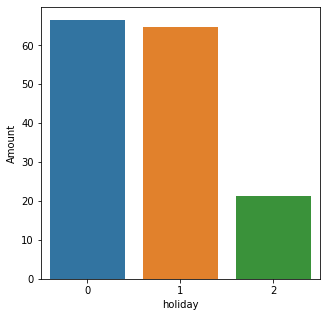

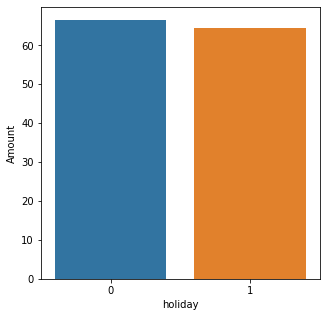

In [5]:
# Fill the missing value
data['temp'].fillna(method='ffill', inplace=True)
data['windspeed'].fillna(method='ffill', inplace=True)
data['humidity'].fillna(method='ffill', inplace=True)
# Recheck after filling the missing value
print('Missing value check : \n', data.isna().sum(),'\n')

#Holiday feature status and count
fig = plt.figure(figsize=[5,5])
sns.barplot(x='holiday',y='Amount',data=data.groupby('holiday')['Amount'].mean().reset_index())

# Processing the holiday feature
for i in range(len(data)):
  if data['holiday'][i]==2:
    data['holiday'][i]=1

#Recheck the holiday feature
fig = plt.figure(figsize=[5,5])
sns.barplot(x='holiday',y='Amount',data=data.groupby('holiday')['Amount'].mean().reset_index())

In [6]:
# Add month and hour and year features from the original datetime feature
data['month'] = data['DateTime'].dt.month
data['hour'] = data['DateTime'].dt.hour
data['year'] = data['DateTime'].dt.year
data1 = data.copy()
data0=data.set_index('DateTime', drop=True, inplace=False)

In [7]:
# Moving the target Amount feature to the last position
print('Before moving:',data0.columns)
data0=data0[['temp', 'windspeed', 'humidity', 'holiday','month', 'hour','year','Amount']]
print('After moving:',data0.columns)
# Save the data index and value
data_columns=data0.columns
feature_nameX=list(data_columns)[:-1]

Before moving: Index(['temp', 'windspeed', 'humidity', 'holiday', 'Amount', 'month', 'hour',
       'year'],
      dtype='object')
After moving: Index(['temp', 'windspeed', 'humidity', 'holiday', 'month', 'hour', 'year',
       'Amount'],
      dtype='object')


#Data analysis

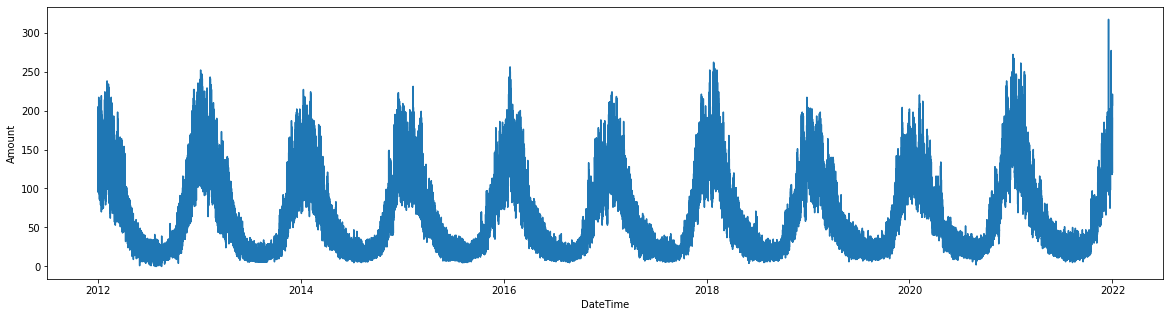

In [8]:
# initial analysis of the Amount usage by the datetime feature


fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data0['Amount'])

plt.ylabel('Amount')
plt.xlabel('DateTime')

plt.show()



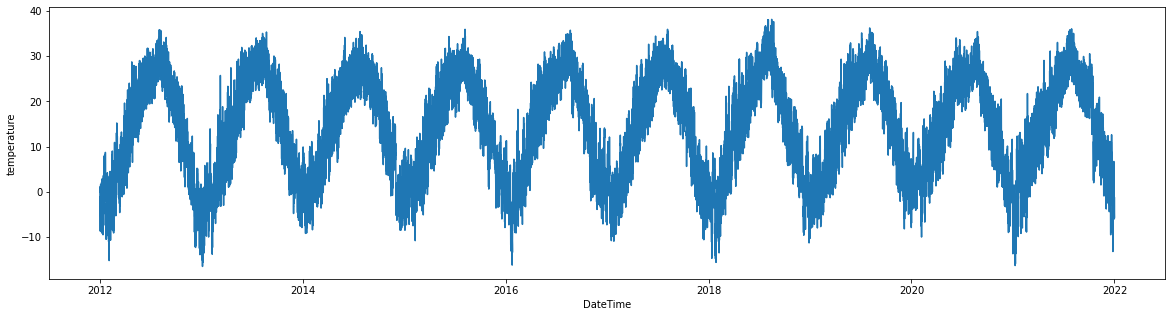

In [9]:
# initial analysis of the Amount usage by the temperature feature

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data0['temp'])
plt.ylabel('temperature')
plt.xlabel('DateTime')
plt.show()

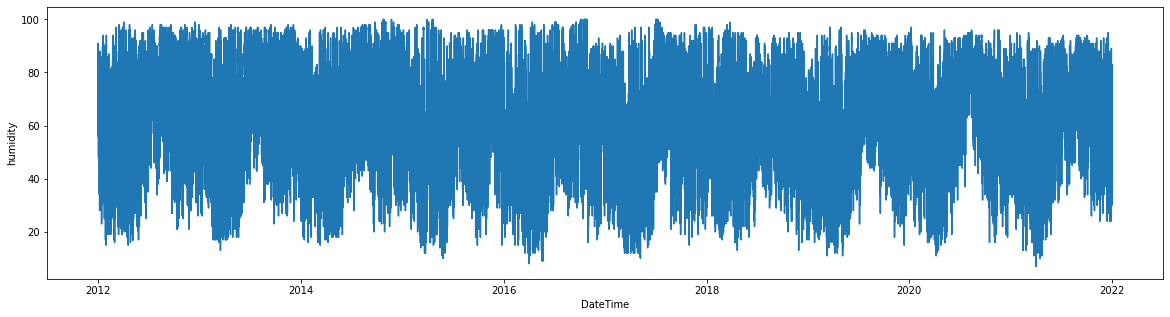

In [10]:
# initial analysis of the Amount usage by the humidity feature

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data0['humidity'])
plt.ylabel('humidity')
plt.xlabel('DateTime')
plt.show()

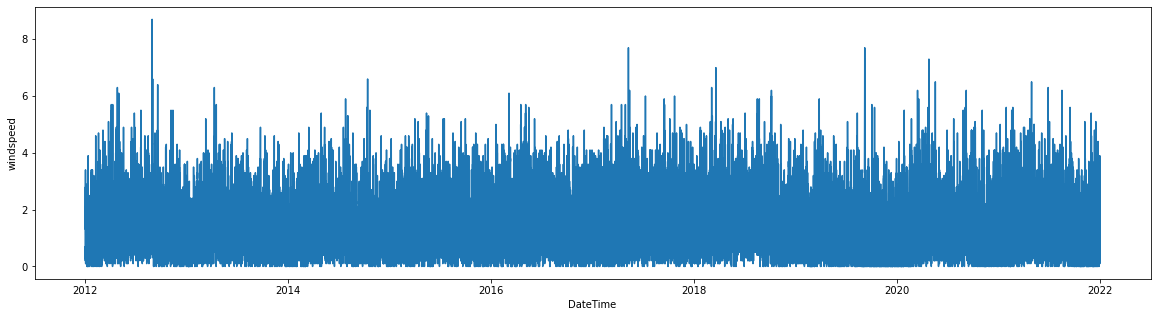

In [ ]:
# initial analysis of the Amount usage by the windspeed feature

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data0['windspeed'])
plt.ylabel('windspeed')
plt.xlabel('DateTime')
plt.show()

In [12]:
# Show the whole dataset

data0.isna().sum()
display(data0)

,temp,windspeed,humidity,holiday,month,hour,year,Amount
DateTime,,,,,,,,
2012-01-01 00:00:00,0.4,0.5,61.0,1,1,0,2012,143
2012-01-01 01:00:00,0.2,0.7,64.0,1,1,1,2012,138
2012-01-01 02:00:00,0.4,0.7,64.0,1,1,2,2012,134
2012-01-01 03:00:00,0.4,0.7,65.0,1,1,3,2012,127
2012-01-01 04:00:00,0.4,0.6,66.0,1,1,4,2012,125
...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,-4.7,1.7,35.0,0,12,19,2021,217
2021-12-31 20:00:00,-4.9,2.1,38.0,0,12,20,2021,221
2021-12-31 21:00:00,-5.0,1.1,36.0,0,12,21,2021,217


In [13]:
# train data and test data partitiioning
splitpoint=365*24
train0 = data0[(data0['year'] >= 2012)  & (data0['year'] < 2020)]
test0 = data0[(data0['year'] == 2020)]
train0=train0[['temp', 'windspeed', 'humidity', 'holiday','month', 'hour','Amount']]
test0=test0[['temp', 'windspeed', 'humidity', 'holiday','month', 'hour','Amount']]
#train0=data0[:-splitpoint] # 2012-2020년
#test0=data0[-splitpoint:] # 2021년
test_index=test0.index
test_columns=test0.columns


plotY = train0['Amount']
plotX = train0.drop(['Amount'], axis = 1)

In [14]:
train_index = train0.index
test_index = test0.index
train_columns = train0.columns
test_columns = test0.columns

In [15]:
ft = np.array(data_columns)[:-1]

In [16]:
# Perform min_max scaling

scaler=MinMaxScaler()
scaler.fit(train0)
print("n_sample_seen_:",scaler.n_samples_seen_, "\n data_min:_",scaler.data_min_,"\n data_max_:", scaler.data_max_,"\n feature_range:", scaler.feature_range)
scaler.partial_fit(test0)
print("n_sample_seen_:",scaler.n_samples_seen_, "\n data_min:_",scaler.data_min_,"\n data_max_:", scaler.data_max_,"\n feature_range:", scaler.feature_range)
dataSet=scaler.transform(train0)
testSet=scaler.transform(test0)



n_sample_seen_: 70128 
 data_min:_ [-16.5   0.    8.    0.    1.    0.    0. ] 
 data_max_: [ 38.1   8.7 100.    1.   12.   23.  262. ] 
 feature_range: (0, 1)
n_sample_seen_: 78912 
 data_min:_ [-16.5   0.    8.    0.    1.    0.    0. ] 
 data_max_: [ 38.1   8.7 100.    1.   12.   23.  262. ] 
 feature_range: (0, 1)


In [17]:
#from sklearn.metrics import davies_bouldin_score
#from matplotlib import pyplot as plt
#plt.legend(loc='upper center')

# data2021 = data1[(data1['DateTime'].dt.year == 2021)]

# data2021['day_of_the_week'] = data2021['DateTime'].dt.day_name()

# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Sunday'], 0)
# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Monday'], 1)
# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Tuesday'], 2)
# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Wednesday'], 3)
# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Thursday'], 4)
# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Friday'], 5)
# data2021['day_of_the_week'] = data2021['day_of_the_week'].replace(['Saturday'], 6)

# x = np.array([0,1,2,3,4,5,6])
# my_xticks = [ 'sun','mon', 'tue', 'wed', 'thu', 'fri', 'sar' ]
# plt.xticks(x, my_xticks)

# group_time = data2021[(data2021['DateTime'].dt.month > 2) & (data2021['DateTime'].dt.month < 6)]
# dataset_month = group_time.groupby(['day_of_the_week']).mean().reset_index()
# ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['day_of_the_week'])

# plt.xticks(x, my_xticks)
# ax.set_xlabel("Day of the week")
# ax = ts.plot()
# ax.set_ylabel("Heat load (Gcal)")





Text(0, 0.5, 'Heat load (Gcal)')

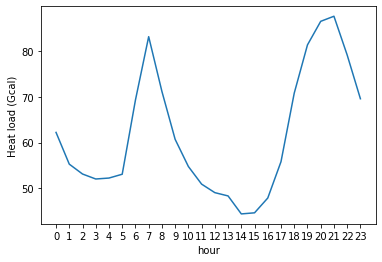

In [18]:
# Heat load analysis by hour (Spring season)

data2021 = data1[(data1['DateTime'].dt.year == 2021)]

group_time = data2021[(data2021['DateTime'].dt.month > 2) & (data2021['DateTime'].dt.month < 6)]
dataset_month = group_time.groupby(['hour']).mean().reset_index()

ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['hour'])

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
my_xticks = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(x, my_xticks)
ax.set_xlabel("Hour")
ax = ts.plot()
ax.set_ylabel("Heat load (Gcal)")


In [ ]:
# group_time = data2021[(data2021['DateTime'].dt.month > 5) & (data2021['DateTime'].dt.month < 9)]
# dataset_month = group_time.groupby(['day_of_the_week']).mean().reset_index()
# ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['day_of_the_week'])
# plt.xticks(x, my_xticks)
# ax = ts.plot()
# ax.set_ylabel("Heat load (Gcal)")
# ax.set_xlabel("Day of the week")



Text(0, 0.5, 'Heat load (Gcal)')

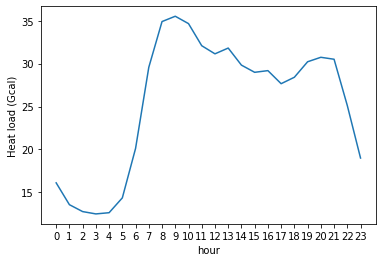

In [19]:

# Heat load analysis by hour (Summer season)

data2021 = data1[(data1['DateTime'].dt.year == 2021)]

group_time = data2021[(data2021['DateTime'].dt.month > 5) & (data2021['DateTime'].dt.month < 9)]
dataset_month = group_time.groupby(['hour']).mean().reset_index()

ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['hour'])

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
my_xticks = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(x, my_xticks)
ax.set_xlabel("hour")
ax = ts.plot()
ax.set_ylabel("Heat load (Gcal)")


In [ ]:
# group_time = data2021[(data2021['DateTime'].dt.month > 8) & (data2021['DateTime'].dt.month < 12)]
# dataset_month = group_time.groupby(['day_of_the_week']).mean().reset_index()
# ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['day_of_the_week'])
# plt.xticks(x, my_xticks)
# ax = ts.plot()
# ax.set_ylabel("Heat load (Gcal)")
# ax.set_xlabel("Day of the week")




Text(0, 0.5, 'Heat load (Gcal)')

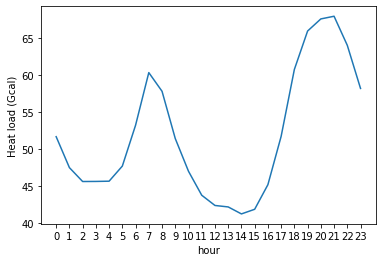

In [20]:
# Heat load analysis by hour (Fall season)

data2021 = data1[(data1['DateTime'].dt.year == 2021)]

group_time = data2021[(data2021['DateTime'].dt.month > 8) & (data2021['DateTime'].dt.month < 12)]
dataset_month = group_time.groupby(['hour']).mean().reset_index()

ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['hour'])

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
my_xticks = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(x, my_xticks)
ax.set_xlabel("hour")
ax = ts.plot()
ax.set_ylabel("Heat load (Gcal)")


In [ ]:

# group_time = data2021[(data2021['DateTime'].dt.month == 12) | (data2021['DateTime'].dt.month == 1) | (data2021['DateTime'].dt.month == 2)]
# dataset_month = group_time.groupby(['day_of_the_week']).mean().reset_index()
# ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['day_of_the_week'])
# plt.xticks(x, my_xticks)
# ax = ts.plot()
# ax.set_ylabel("Heat load (Gcal)")
# ax.set_xlabel("Day of the week")



#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 

Text(0, 0.5, 'Heat load (Gcal)')

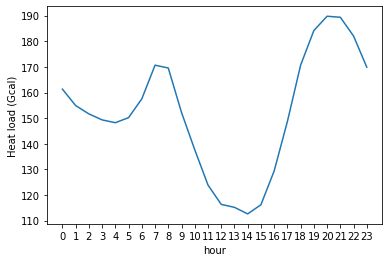

In [21]:
# Heat load analysis by hour (Winter season)

data2021 = data1[(data1['DateTime'].dt.year == 2021)]

group_time = data2021[(data2021['DateTime'].dt.month == 12) | (data2021['DateTime'].dt.month == 1) | (data2021['DateTime'].dt.month == 2)]
dataset_month = group_time.groupby(['hour']).mean().reset_index()

ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['hour'])

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
my_xticks = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(x, my_xticks)
ax.set_xlabel("hour")
ax = ts.plot()
ax.set_ylabel("Heat load (Gcal)")
#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 

DateTime     2021-08-31 23:00:00
temp                        38.1
windspeed                    8.7
humidity                   100.0
holiday                        1
Amount                        71
month                          8
hour                          23
year                        2021
dtype: object


DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


Text(0.5, 0, 'Heat load (Gcal)')

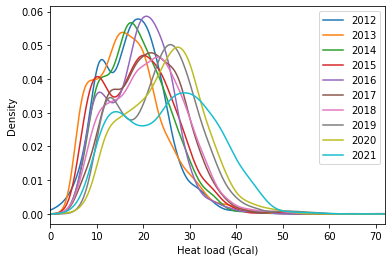

In [22]:
# Heat load density analysis from 2012 to 2021

datas = data1[(data1['DateTime'].dt.month == 6) |  (data1['DateTime'].dt.month == 7)|  (data1['DateTime'].dt.month ==8)]
print(datas.max(axis=0) )

total = []
year = 2012
for i in range(10):
  y_temp = datas[datas['DateTime'].dt.year == year]
  total.append(y_temp['Amount'])
  year+=1
 

df = pd.DataFrame({
    '2012': total[0],
    '2013': total[1],
    '2014': total[2],
    '2015': total[3],
    '2016': total[4],
    '2017': total[5],
    '2018': total[6],
    '2019': total[7],
    '2020': total[8],
    '2021': total[9],
})

ax = df.plot.kde()

x = datas.mean()
kdeline = ax.lines[-1]
ymax = np.interp(x, kdeline.get_xdata(), kdeline.get_ydata())
#ax.vlines(x=data.mean(), ymin=0, ymax=ymax, linestyles="dotted")
ax.set_xlim(xmin=0,xmax=72)
ax.set_xlabel("Heat load (Gcal)")

#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 

,DateTime,temp,windspeed,humidity,holiday,Amount,month,hour,year
9,2012-01-01 09:00:00,0.4,0.3,77.0,1,133,1,9,2012
10,2012-01-01 10:00:00,0.3,0.6,83.0,1,128,1,10,2012
11,2012-01-01 11:00:00,0.6,1.2,83.0,1,119,1,11,2012
12,2012-01-01 12:00:00,1.1,1.5,74.0,1,113,1,12,2012
13,2012-01-01 13:00:00,0.6,2.1,78.0,1,119,1,13,2012
...,...,...,...,...,...,...,...,...,...
87661,2021-12-31 13:00:00,-1.7,2.7,34.0,0,126,12,13,2021
87662,2021-12-31 14:00:00,-1.2,2.8,35.0,0,120,12,14,2021
87663,2021-12-31 15:00:00,-2.0,3.9,36.0,0,149,12,15,2021
87664,2021-12-31 16:00:00,-2.3,3.2,37.0,0,155,12,16,2021


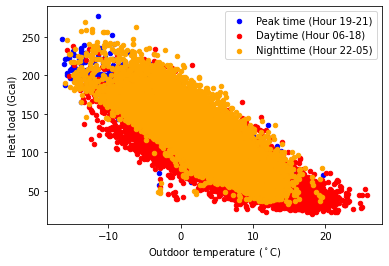

In [23]:
# Heat load pattern analysis by the outdoor temperature feature

datax = data1[(data1['DateTime'].dt.month == 11) |  (data1['DateTime'].dt.month == 12)|  (data1['DateTime'].dt.month == 1)|  (data1['DateTime'].dt.month == 2)|  (data1['DateTime'].dt.month == 3)]


peak_time = datax[ (datax['DateTime'].dt.hour == 6) |(datax['DateTime'].dt.hour == 7) ]
#transient = datax[(datax['DateTime'].dt.hour == 21)  |  (datax['DateTime'].dt.hour == 5)]
day_time = datax[(datax['DateTime'].dt.hour >= 9)  &  (datax['DateTime'].dt.hour <= 17)]
night_time = datax[(datax['DateTime'].dt.hour == 22) | (datax['DateTime'].dt.hour == 23)  |  (datax['DateTime'].dt.hour == 24)  |  (datax['DateTime'].dt.hour == 1)  |  (datax['DateTime'].dt.hour == 2) |  (datax['DateTime'].dt.hour == 3) |  (datax['DateTime'].dt.hour == 4) |  (datax['DateTime'].dt.hour == 5) ]

df1 = peak_time[['Amount','temp']]
ax = df1.plot.scatter(x = 'temp' , y ='Amount', c='blue', label='Peak time (Hour 19-21)');


df2 = day_time[['Amount','temp']]
df2.plot.scatter(x = 'temp' , y = 'Amount',ax=ax,c='red', label='Daytime (Hour 06-18)');

df3 = night_time[['Amount','temp']]
df3.plot.scatter(x = 'temp' , y = 'Amount',ax=ax,c='orange', label='Nighttime (Hour 22-05)');

#df4 = transient[['Amount','temp']]
#df4.plot.scatter(x = 'temp' , y = 'Amount',ax=ax,c='green', label='transients (h 22-05)');
ax.set_xlabel("Outdoor temperature ($^\circ$C)")
ax.set_ylabel("Heat load (Gcal)")
display(day_time)

#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


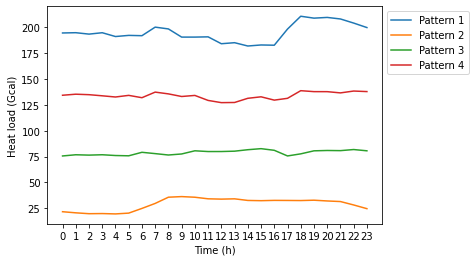

In [25]:
# Heat load pattern anaysis by clustering
from sklearn.metrics import davies_bouldin_score
from matplotlib import pyplot as plt
time_graph = data1[(data1['DateTime'] >= '2021-1-1') & (data1['DateTime'] <= '2021-12-31')]
time_graph['Time (h)'] = time_graph['DateTime']
df1 = time_graph[['Amount','Time (h)']]
df1['Time (h)']  = pd.to_datetime(time_graph.DateTime).dt.hour


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=30).fit(df1)
y = kmeans.labels_
#print(y)
# plt.subplot(224)
# plt.scatter(df1.iloc[:, 1], df1.iloc[:, 0], c=kmeans)
# plt.title("Unevenly Sized Blobs")

# plt.show()

for i in range(4):
   cluster_i = df1[y == i] 
   #print(cluster_i)
   dataset_month = cluster_i.groupby(['Time (h)']).mean().reset_index()
 
   ts = pd.Series(dataset_month['Amount'].values, index=dataset_month['Time (h)'])
   
   ax = ts.plot(legend=True,label='Pattern '+str(i+1))
   ax.legend(bbox_to_anchor=(1.0, 1.0))
   ax.set_ylabel("Heat load (Gcal)")
   plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
   #plt.savefig('filename.png', dpi=600)
   #from google.colab import files
   #files.download("filename.png") 

# LightGBM Regressor

In [26]:
!pip install lightgbm
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:

trainX = dataSet[:,:-1]
trainY = dataSet[:, [-1]]
print("trainX",trainX.shape, ", trainY", trainY.shape)
testX = testSet[:,:-1]
testY = testSet[:, [-1]]
print("testX",testX.shape, ", testY", testY.shape)

trainX (70128, 6) , trainY (70128, 1)
testX (8784, 6) , testY (8784, 1)


In [28]:
# Perform gridsearchCV in order to decide the best hyperparameters

from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: %2.3f' % mse)
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print('R2: %2.3f' % r2)
     return r2

def two_score(y_true,y_pred):    
    MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = R2(y_true,y_pred)
    return score

def two_scorer():
    return make_scorer(two_score, greater_is_better=True) 



model01=LGBMRegressor()

param_grid = {
    'num_leaves': [6,8,12,16,18,24],
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24]
    }
grid = GridSearchCV(model01, param_grid, verbose=1, cv=5, n_jobs=-1, scoring=two_scorer())
# Run the grid
grid.fit(trainX, trainY)


print(grid.best_params_)
print(grid.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


{'learning_rate': 0.01, 'n_estimators': 24, 'num_leaves': 24}
0.31782145572432574


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Processing time: 0.8106272220611572 s
r2_score :  0.950146110174898
mean_squared_error :  0.0017955012630708875
mean_absolute_percentage_error :  0.14983536852026869


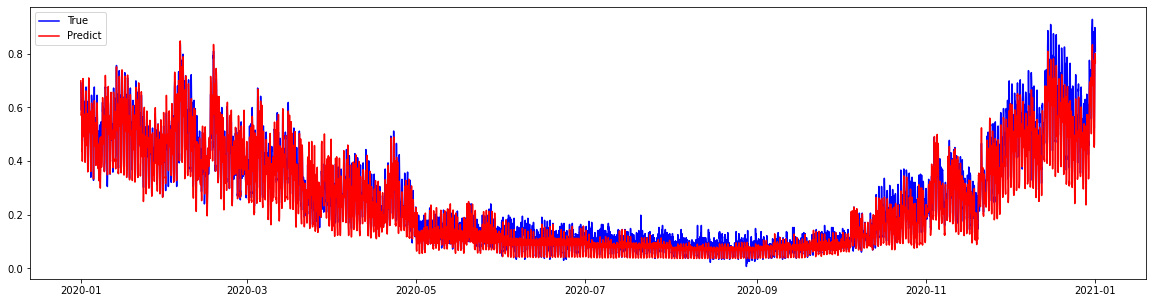

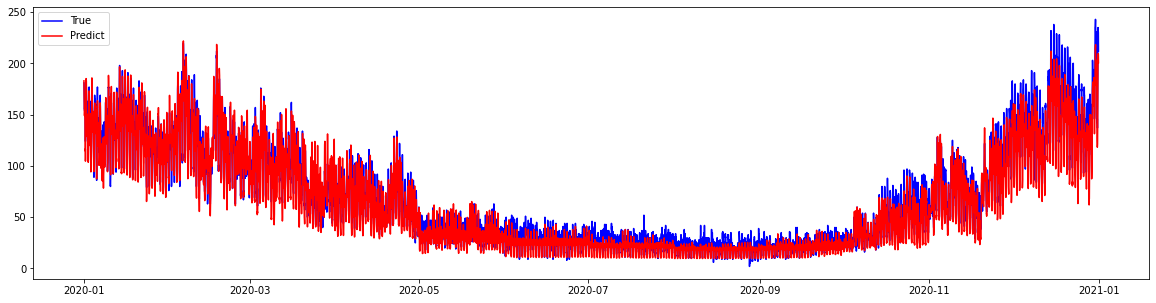

r2_score :  0.950146110174898
mean_squared_error :  123.25038870223801
mean_absolute_percentage_error :  0.14983536852026869


In [29]:
# Train the LGBRegression model 

model01=LGBMRegressor()
start=time.time()
# Train the model
model01.fit(trainX, trainY)
# Test the model
model01_preds = model01.predict(testX)
model01_score = np.sqrt(mean_squared_error(testY, model01_preds))
model01_r2_score = r2_score(testY, model01_preds)
end=time.time()
print("Processing time:",end-start,"s")
# Check the evaluation scores (before normalization of the minmax scaler)
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(testY, model01_preds))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(testY, model01_preds))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(testY, model01_preds))
# Plot the graph
plt.figure(figsize=(20,5))
plt.plot(test_index,testY,label='True',color='blue')
plt.plot(test_index,model01_preds,label='Predict',color='red')
plt.legend()
plt.show()
# Check the evaluation scores (after normalization of the minmax scaler)
actual_testSet01=np.concatenate((testX, testY) , axis=1)
model01_pred=np.reshape(model01_preds,(-1,1))
predict_testSet01=np.concatenate((testX, model01_pred), axis=1)
back_actual_testSet01 = scaler.inverse_transform(actual_testSet01)
back_predict_testSet01 = scaler.inverse_transform(predict_testSet01)
back_actual01 = back_actual_testSet01[:,[-1]]
back_predict01 = back_predict_testSet01[:,[-1]]
#  Plot the graph
plt.figure(figsize=(20,5))
plt.plot(test_index,back_actual01,label='True',color='blue')
plt.plot(test_index, back_predict01,label='Predict',color='red')
plt.legend()
plt.show()
# Show the final score
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(back_actual01, back_predict01))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(back_actual01, back_predict01))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(back_actual01, back_predict01))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

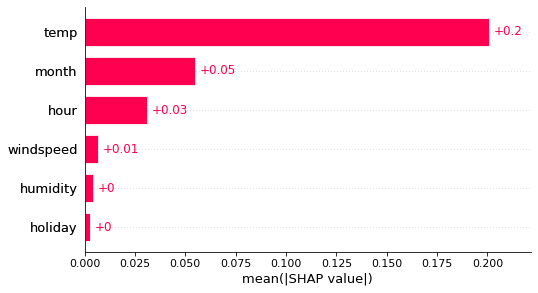

In [30]:
# Show the feature importance using the shap explainer
importances = model01.feature_importances_
indices = np.argsort(importances)
variable_names = ['temp','windpeed','humidity','holiday','month','hour','year']

#plt.title('Feature Importances')
#plt.barh(range(len(indices)), importances[indices], color='g', align='center')
#plt.yticks(range(len(indices)), [variable_names[i] for i in indices])
#plt.xlabel('Relative Importance')



explainer = shap.Explainer(model01)
shap_values = explainer(plotX)
shap.plots.bar(shap_values, show=False)
#plt.show()

#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 





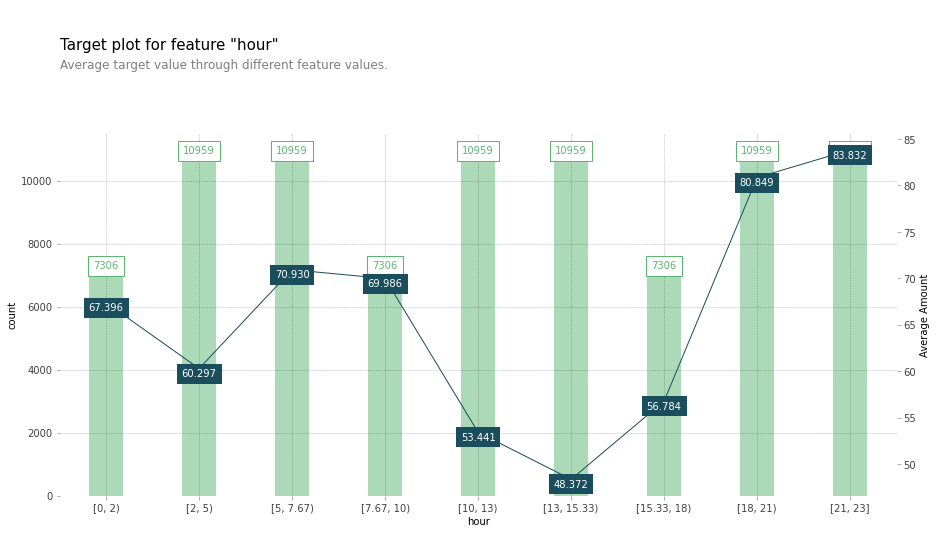

In [31]:
# pdpbox feature analysis
from pdpbox import pdp, get_dataset, info_plots

fig, axes, summary_df = info_plots.target_plot(
    df=data0, feature='hour', feature_name='hour', target='Amount'
)


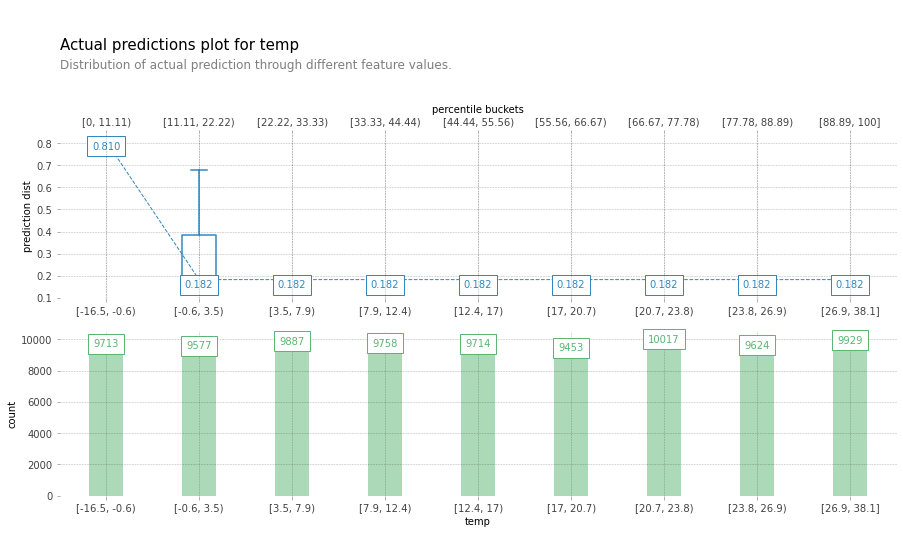

In [32]:
# pdpbox feature analysis


fig, axes, summary_df = info_plots.actual_plot(
    model=model01, X=data0[['temp', 'windspeed', 'humidity', 'holiday', 'month', 'hour']], feature='temp', feature_name='temp', 
    show_percentile=True
)


#plt.savefig('filename.png', dpi=600)
#from google.colab import files
# pdpbox feature analysis#files.download("filename.png") 

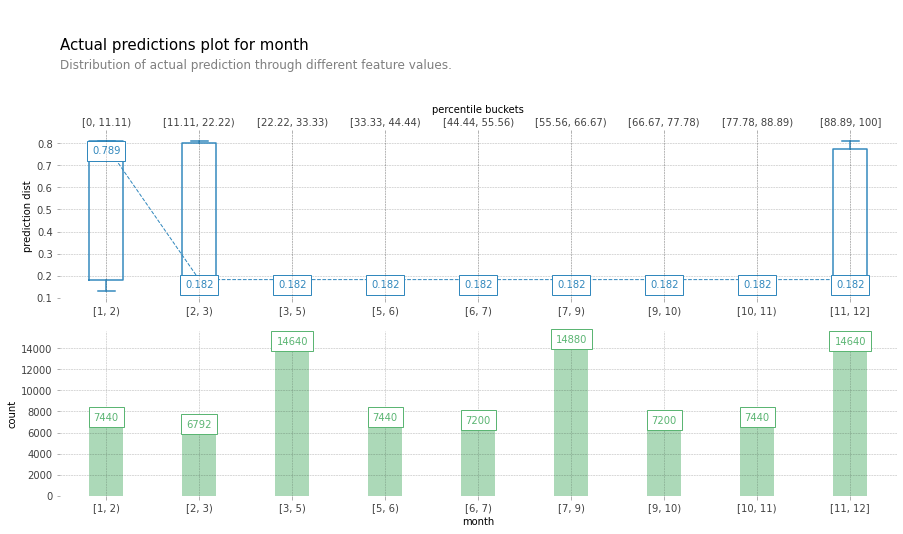

In [33]:
# pdpbox feature analysis

fig, axes, summary_df = info_plots.actual_plot(
    model=model01, X=data0[['temp', 'windspeed', 'humidity', 'holiday', 'month', 'hour']], feature='month', feature_name='month', 
    show_percentile=True
)


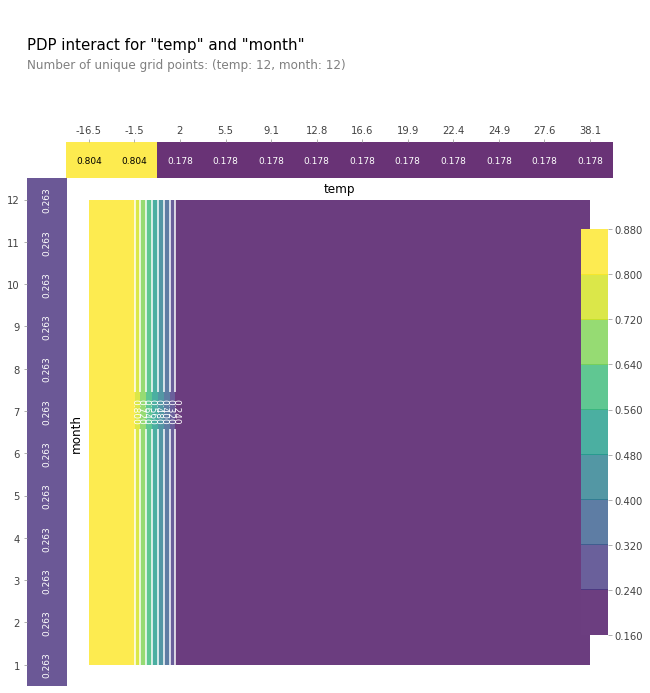

In [34]:
# pdpbox feature analysis

inter_rf = pdp.pdp_interact(
    model=model01, dataset=data0, model_features=['temp', 'windspeed', 'humidity', 'holiday', 'month', 'hour'], num_grid_points=[12, 12],
    features=['temp','month' ]
)
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['temp', 'month'], x_quantile=True, plot_type='contour', plot_pdp=True,
)

#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 



[23:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
소요시간: 5.4218621253967285 초
r2_score :  0.9672292945218113
mean_squared_error :  91.1611423335866
mean_absolute_percentage_error :  2371912592749.3296


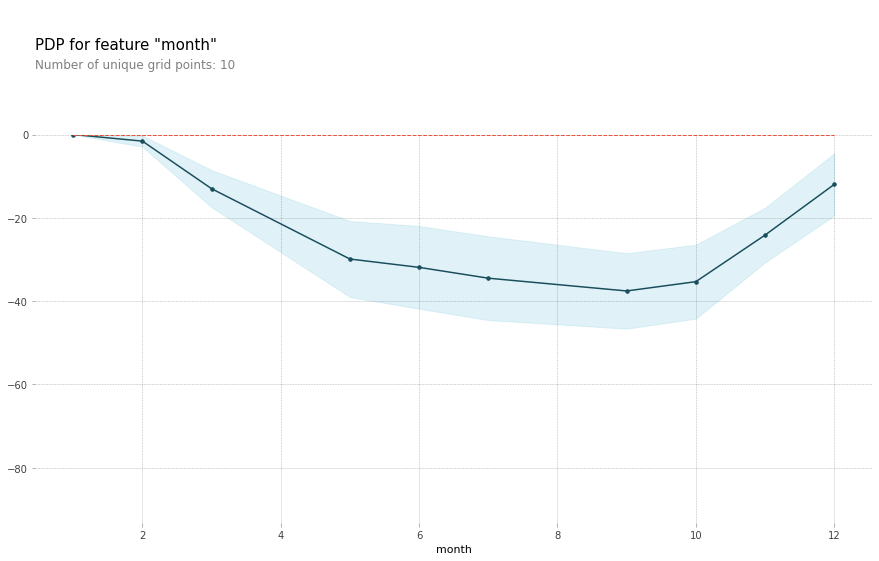

In [35]:
# Test the XGBoost model

import xgboost
model01=xgboost.XGBRegressor()
start=time.time()
# Train
model01.fit(plotX, plotY)
# Test
model01_preds = model01.predict(plotX)
model01_score = np.sqrt(mean_squared_error(plotY, model01_preds))
model01_r2_score = r2_score(plotY, model01_preds)
end=time.time()
print("Running time:",end-start,"s")

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(plotY, model01_preds))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(plotY, model01_preds))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(plotY, model01_preds))


from pdpbox import pdp, get_dataset, info_plots
feature_names=['temp','windspeed', 'humidity','holiday','month','hour']
pdp_goals = pdp.pdp_isolate(model=model01, dataset=plotX, model_features=feature_names, feature='month')

# plot it
pdp.pdp_plot(pdp_goals, 'month')
plt.show()

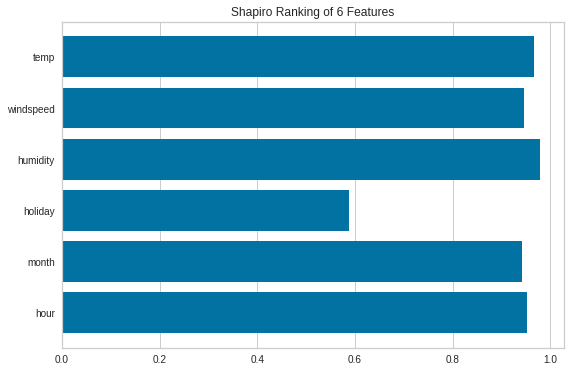

In [36]:

# Yellowbrick analysis

import yellowbrick as yb 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
# Feature Analysis Imports 
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import PCADecomposition
from yellowbrick.features import Rank1D, Rank2D 
from yellowbrick.features import RadViz 


mpl.rcParams["figure.figsize"] = (9,6)

variable_names = plotX.columns

visualizer = Rank1D(features=variable_names, algorithm='shapiro')

visualizer.fit(plotX,plotY)                # Fit the data to the visualizer
visualizer.transform(plotX)             # Transform the data
#plt.savefig('filename.png', dpi=600)
#from google.colab import files
#files.download("filename.png") 

visualizer.show()            

1.2710208892822266 초


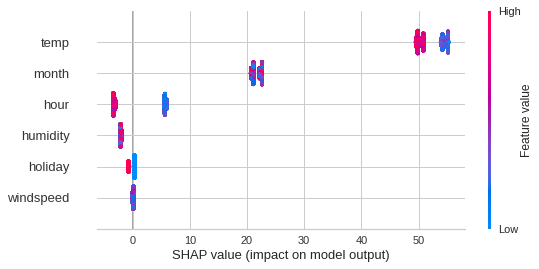

In [37]:
#Shap explainer

explainer01 = shap.TreeExplainer(model01)
start=time.time()
shap_values01 = explainer01.shap_values(testX)
end=time.time()
print(end-start,"초")
# SHAP plot
shap.summary_plot(shap_values01, testX, feature_names=ft)

# XGBoost Regressor

In [38]:
import xgboost

In [39]:

trainX = dataSet[:,:-1]
trainY = dataSet[:, [-1]]
print("trainX",trainX.shape, ", trainY", trainY.shape)
testX = testSet[:,:-1]
testY = testSet[:, [-1]]
print("testX",testX.shape, ", testY", testY.shape)

trainX (70128, 6) , trainY (70128, 1)
testX (8784, 6) , testY (8784, 1)


[23:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
소요시간: 2.5121543407440186 초
r2_score :  0.9439894995858442
mean_squared_error :  0.0020172332508387857
mean_absolute_percentage_error :  0.15771542186670742


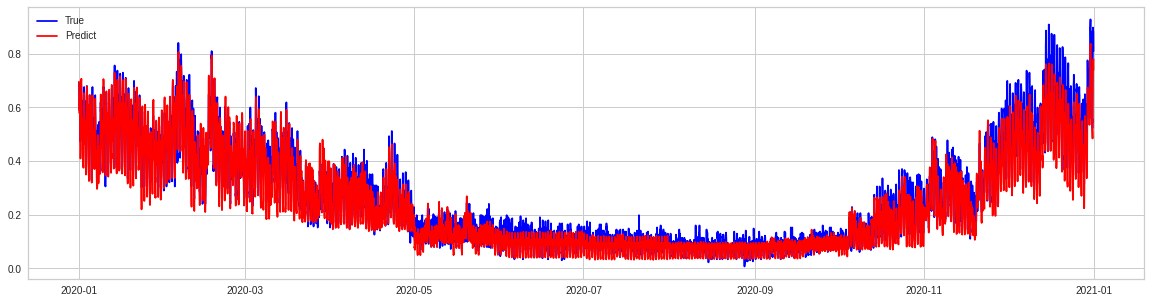

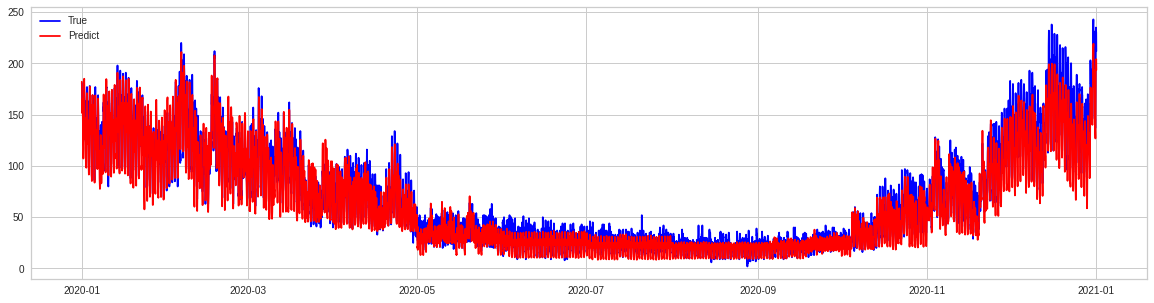

r2_score :  0.9439894995858442
mean_squared_error :  138.47095927057762
mean_absolute_percentage_error :  0.15771542186670742


In [40]:
model02=xgboost.XGBRegressor()
start=time.time()
# Train
model02.fit(trainX, trainY)
# Test
model02_preds = model02.predict(testX)
model02_score = np.sqrt(mean_squared_error(testY, model02_preds))
model02_r2_score = r2_score(testY, model02_preds)
end=time.time()
print("Running time:",end-start,"s")
# Check the evaluation metrics
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(testY, model02_preds))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(testY, model02_preds))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(testY, model02_preds))
# Plotting
plt.figure(figsize=(20,5))
plt.plot(test_index,testY,label='True',color='blue')
plt.plot(test_index,model02_preds,label='Predict',color='red')
plt.legend()
plt.show()
# Perform minmax scaler revert
actual_testSet02=np.concatenate((testX, testY) , axis=1)
model02_pred=np.reshape(model02_preds,(-1,1))
predict_testSet02=np.concatenate((testX, model02_pred), axis=1)
back_actual_testSet02 = scaler.inverse_transform(actual_testSet02)
back_predict_testSet02 = scaler.inverse_transform(predict_testSet02)
back_actual02 = back_actual_testSet02[:,[-1]]
back_predict02 = back_predict_testSet02[:,[-1]]
# The graph after inmax scaler revert
plt.figure(figsize=(20,5))
plt.plot(test_index,back_actual02,label='True',color='blue')
plt.plot(test_index, back_predict02,label='Predict',color='red')
plt.legend()
plt.show()
# Evaluation metrics after minmax scaler revert
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(back_actual02, back_predict02))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(back_actual02, back_predict02))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(back_actual02, back_predict02))

0.6991655826568604 초


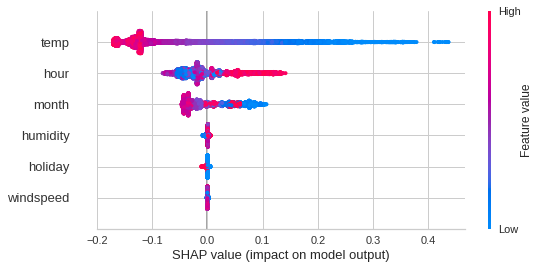

In [41]:
explainer02 = shap.TreeExplainer(model02)
start=time.time()
shap_values02 = explainer02.shap_values(testX)
end=time.time()
print(end-start,"s")
# SHAP plot
shap.summary_plot(shap_values02, testX, feature_names=ft)

# Adaboost

In [42]:
from sklearn.ensemble import AdaBoostRegressor

In [43]:

trainX = dataSet[:,:-1]
trainY = dataSet[:, [-1]]
print("trainX",trainX.shape, ", trainY", trainY.shape)
testX = testSet[:,:-1]
testY = testSet[:, [-1]]
print("testX",testX.shape, ", testY", testY.shape)

trainX (70128, 6) , trainY (70128, 1)
testX (8784, 6) , testY (8784, 1)


In [44]:
testY_ravel = np.ravel(testY)
trainY_ravel = np.ravel(trainY)
print("testX",testX.shape, ", testY", testY_ravel.shape)




testX (8784, 6) , testY (8784,)


소요시간: 3.772839307785034 초
r2_score :  0.9085087760157413
mean_squared_error :  0.003295081061877842
mean_absolute_percentage_error :  0.30761051718378524


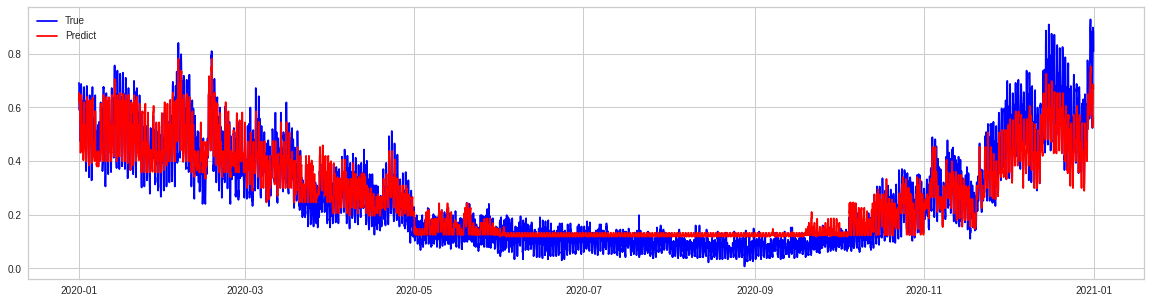

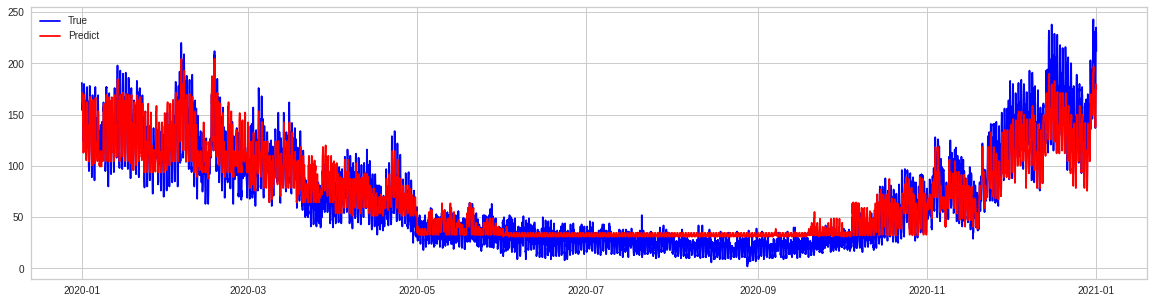

r2_score :  0.9085087760157413
mean_squared_error :  226.18754441154258
mean_absolute_percentage_error :  0.30761051718378524


In [46]:
model03=AdaBoostRegressor()
start=time.time()
# Training
model03.fit(trainX, trainY)
# Testing
model03_preds = model03.predict(testX)
model03_score = np.sqrt(mean_squared_error(testY, model03_preds))
model03_r2_score = r2_score(testY, model03_preds)
end=time.time()
print("Running time:",end-start,"s")
# Check the evaluation metrics (before minmax scaler revert)
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(testY, model03_preds))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(testY, model03_preds))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(testY, model03_preds))
# Plotting
plt.figure(figsize=(20,5))
plt.plot(test_index,testY,label='True',color='blue')
plt.plot(test_index,model03_preds,label='Predict',color='red')
plt.legend()
plt.show()
# minmax scaler revert
actual_testSet03=np.concatenate((testX, testY) , axis=1)
model03_pred=np.reshape(model03_preds,(-1,1))
predict_testSet03=np.concatenate((testX, model03_pred), axis=1)
back_actual_testSet03 = scaler.inverse_transform(actual_testSet03)
back_predict_testSet03 = scaler.inverse_transform(predict_testSet03)
back_actual03 = back_actual_testSet03[:,[-1]]
back_predict03 = back_predict_testSet03[:,[-1]]
# Plotting (after revert)
plt.figure(figsize=(20,5))
plt.plot(test_index,back_actual03,label='True',color='blue')
plt.plot(test_index, back_predict03,label='Predict',color='red')
plt.legend()
plt.show()
# Check the evaluation metrics (after minmax scaler revert)
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(back_actual03, back_predict03))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(back_actual03, back_predict03))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(back_actual03, back_predict03))

2.2811906337738037 초


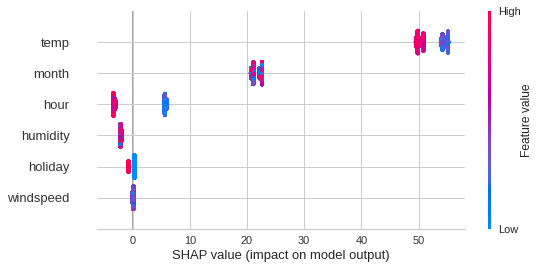

In [47]:
explainer03 = shap.KernelExplainer(model03.predict, testX)
start=time.time()
shap_values03 = explainer01.shap_values(testX)
end=time.time()
print(end-start,"s")
# SHAP plot
shap.summary_plot(shap_values03, testX, feature_names=ft)

# MLP Regressor

In [48]:
from sklearn.neural_network import MLPRegressor

In [49]:

trainX = dataSet[:,:-1]
trainY = dataSet[:, [-1]]
print("trainX",trainX.shape, ", trainY", trainY.shape)
testX = testSet[:,:-1]
testY = testSet[:, [-1]]
print("testX",testX.shape, ", testY", testY.shape)

trainX (70128, 6) , trainY (70128, 1)
testX (8784, 6) , testY (8784, 1)


소요시간: 14.051941633224487 초
r2_score :  0.9356645112056062
mean_squared_error :  0.0023170599484988266
mean_absolute_percentage_error :  0.171134844989037


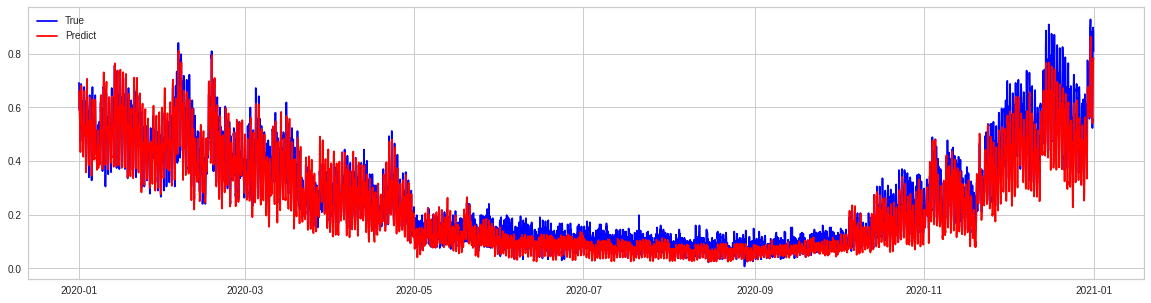

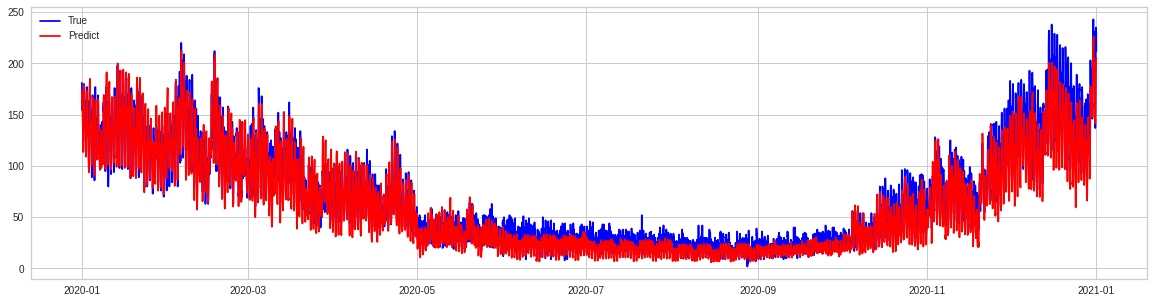

r2_score :  0.9356645112056062
mean_squared_error :  159.05226310475345
mean_absolute_percentage_error :  0.17113484498903697


In [50]:
model04=MLPRegressor()
start=time.time()
# Train
model04.fit(trainX, trainY)
# test
model04_preds = model04.predict(testX)
model04_score = np.sqrt(mean_squared_error(testY, model04_preds))
model04_r2_score = r2_score(testY, model04_preds)
end=time.time()
print("Running time:",end-start,"s")
# Check the evaluation metrics (before minmax scaler revert)
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(testY, model04_preds))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(testY, model04_preds))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(testY, model04_preds))
# Plotting
plt.figure(figsize=(20,5))
plt.plot(test_index,testY,label='True',color='blue')
plt.plot(test_index,model04_preds,label='Predict',color='red')
plt.legend()
plt.show()
# Minmax scaler revert
actual_testSet04=np.concatenate((testX, testY) , axis=1)
model04_pred=np.reshape(model04_preds,(-1,1))
predict_testSet04=np.concatenate((testX, model04_pred), axis=1)
back_actual_testSet04 = scaler.inverse_transform(actual_testSet04)
back_predict_testSet04 = scaler.inverse_transform(predict_testSet04)
back_actual04 = back_actual_testSet04[:,[-1]]
back_predict04 = back_predict_testSet04[:,[-1]]
# Plotting
plt.figure(figsize=(20,5))
plt.plot(test_index,back_actual04,label='True',color='blue')
plt.plot(test_index, back_predict04,label='Predict',color='red')
plt.legend()
plt.show()
# Check the evaluation metrics (after minmax scaler revert)
from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(back_actual04, back_predict04))
from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(back_actual04, back_predict04))
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(back_actual04, back_predict04))

1.301133394241333 초


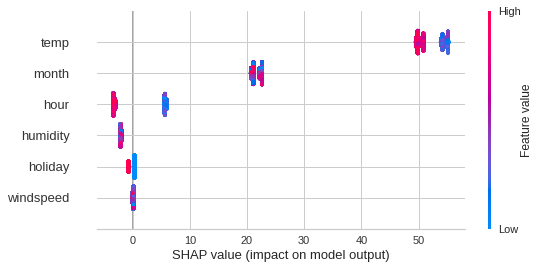

In [51]:
explainer04 = shap.KernelExplainer(model04.predict, testX)
start=time.time()
shap_values04 = explainer01.shap_values(testX)
end=time.time()
print(end-start,"s")
# SHAP plot
shap.summary_plot(shap_values04, testX, feature_names=ft)